In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Loading data

In [2]:
#the files were read one by one and stopwords were removed from the subtitles and titles and the information
#was stored in subtitles_merged_titles.csv
dt=pd.read_csv('subtitles_merged_titles.csv')
dt.head()

,Unnamed: 0,subtitle,title,title_tokenized
0,0,city lights people city donate monument peace ...,City Lights.csv,city light
1,1,good morning good morning billion strings play...,The Brave Little Toaster.csv,brave toaster
2,2,talk motherfucker hear talk fucker motherfucke...,Hostage.csv,hostage
3,3,derek fuck black guy break car long honey dann...,American History X.csv,american history x
4,4,tv news show theme music announcer tv fans spo...,The Perfect Game.csv,perfect game


In [3]:
dt.head()       
f=dt['title'].str.split(".",n=1, expand = True)
dt['title']=f[0].str.lower()


In [4]:
#movie Ratings

movie=pd.read_csv('MPAA_data_commonsensemedia.csv')
print('movie.shape',movie.shape) 
movie.head()
#movie.drop('url',inplace=True)
movie['title']=movie['title'].str.lower()
movie.head()

movie.shape (8889, 3)


,url,title,MPAA_rating
0,logan,logan,R
1,the-great-wall,the great wall,PG-13
2,rock-dog,rock dog,PG
3,the-space-between-us,the space between us,PG-13
4,bambi,bambi,G


In [5]:
movie['MPAA_rating'].value_counts()

R        2387
NR       2304
PG-13    2036
PG       1542
G         612
NC-17       8
Name: MPAA_rating, dtype: int64

###### Storing the different types of ratings that  I have in 'Ratings'

In [6]:
Ratings=movie['MPAA_rating'].unique() 
print(Ratings)

['R' 'PG-13' 'PG' 'G' 'NR' 'NC-17']


In [7]:
movie['MPAA_rating'].value_counts()

R        2387
NR       2304
PG-13    2036
PG       1542
G         612
NC-17       8
Name: MPAA_rating, dtype: int64

##### We have the following number of data sets for each class
- R        : 2387
,NR       : 2304
,PG-13    : 2036
,PG       : 1542
,G        : 612
,NC-17    : 8

- We will discard the class 'NC-17' due to less number of observations.

### Merging data sets

#### Merging movie and commonsense data sets

In [8]:
final_df=dt.merge(movie,on='title',how='inner') 
final_df.shape


(3815, 6)

#### Upon merging final and with subtitles , some movies were repeated. Let us generate a list of these movies and drop the repeated ones.

In [9]:
#Generating a list of repeated movies
#dt['title'].value_counts()
final_df['movies_counter']=final_df.title.map(final_df['title'].value_counts()) 
repeated_movies=[]
for i in range(len(final_df)):
    if final_df['movies_counter'][i] != 1:
        repeated_movies.append(final_df['title'][i])
        
#repeated movies stores names of the movies that are repeated
repeated_movies=set(repeated_movies)
repeated_movies=list(repeated_movies) 
# print('repeated movies training',repeated_movies)




                                                     


In [10]:
#Dropping the movies which were repeated
b= []
for i in range(len(repeated_movies)):
    b=list(final_df[final_df['title']==repeated_movies[i]].index ) 
    b.pop()
    final_df.iloc[[b]]='null'
    
null_indices=list(final_df[final_df['title']=='null'].index)
# print('null_indices',null_indices)
final_df.drop(final_df.index[null_indices],inplace=True)






/anaconda3/lib/python3.6/site-packages/pandas/core/internals/blocks.py:920: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values[indexer] = value


In [11]:
len(final_df)

3774

In [12]:
final_df=final_df[final_df['MPAA_rating'] != 'NC-17']
final_df['MPAA_rating'].value_counts()

R        1310
PG-13    1119
PG        704
NR        405
G         233
Name: MPAA_rating, dtype: int64

### Finding the most frequently occuring words in different classes

In [13]:
X=final_df
G=X[X['MPAA_rating']=='G']
PG_13=X[X['MPAA_rating']=='PG-13']
PG=X[X['MPAA_rating']=='PG']
R=X[X['MPAA_rating']=='R']
NR=X[X['MPAA_rating']=='NR']
final_features=[]


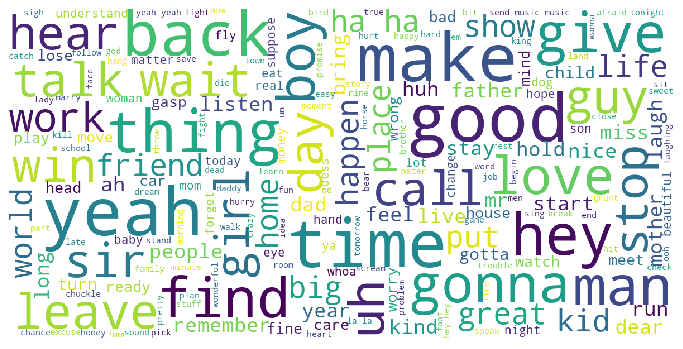

In [14]:
#G
G_sub=G['subtitle'].values


from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tfidf_vec=TfidfVectorizer(max_features=2000)

tfidf_whtspc_stem=tfidf_vec.fit_transform(G_sub)
tfidf_whtspc_stem_features=tfidf_vec.get_feature_names() 
# c_model=count_words.fit_transform(G_sub)
# c_features=count_words.get_feature_names()
final_features=final_features+tfidf_whtspc_stem_features

G_features=tfidf_whtspc_stem_features
from collections import Counter
c=Counter(G_features)

from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(G_sub)

In [18]:
tfidf_whtspc_stem


<233x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 119800 stored elements in Compressed Sparse Row format>

<BarContainer object of 50 artists>

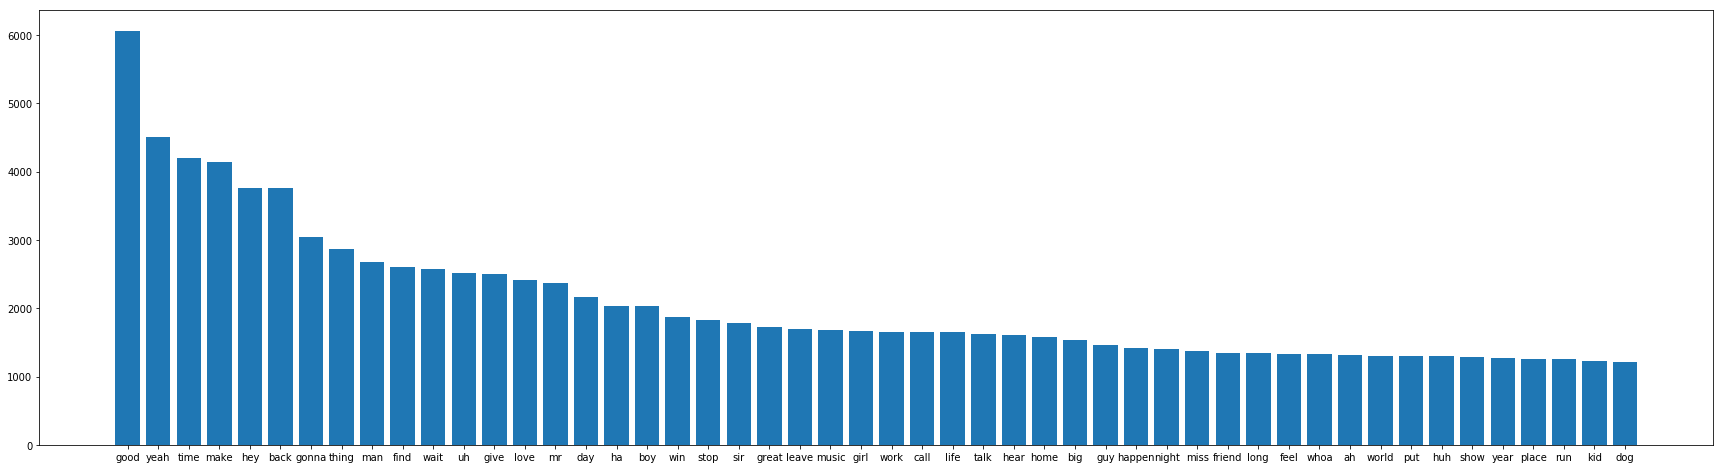

In [19]:
count_words=CountVectorizer(max_features=2000)
c_model=count_words.fit_transform(G_sub)
c_features=count_words.get_feature_names()

c_dt=pd.DataFrame(c_model.todense(),columns=c_features)
d=list(c_dt.sum())

c_features=list(c_features)
c_features_count=pd.DataFrame({'features':c_features,'count':d})
# plt.figure(figsize=(30,8))
# plt.bar(c_features[:50],d[:50])
c_features_count=c_features_count.sort_values(by=['count'],ascending=False)
plt.figure(figsize=(30,8))
plt.bar(c_features_count['features'][:50],c_features_count['count'][:50])

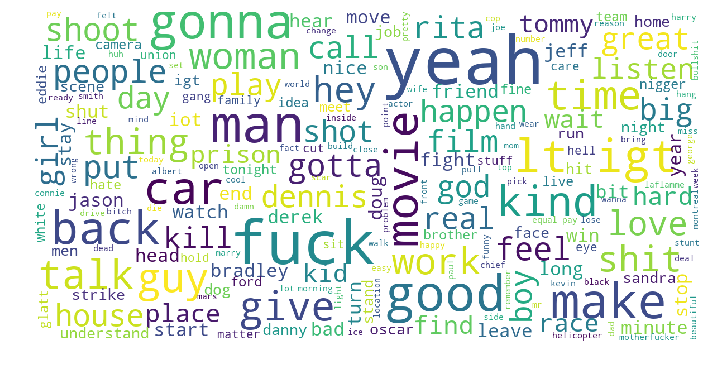

In [21]:
#R
R_sub=R['subtitle'].values
R_tokenized=[]
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec=TfidfVectorizer(max_features=2000)
tfidf_whtspc_stem=tfidf_vec.fit_transform(R_sub)
tfidf_whtspc_stem_features=tfidf_vec.get_feature_names() 

final_features=final_features+tfidf_whtspc_stem_features

R_features=tfidf_whtspc_stem_features
from collections import Counter
c=Counter(R_features)

from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        #stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(R_sub)

<BarContainer object of 50 artists>

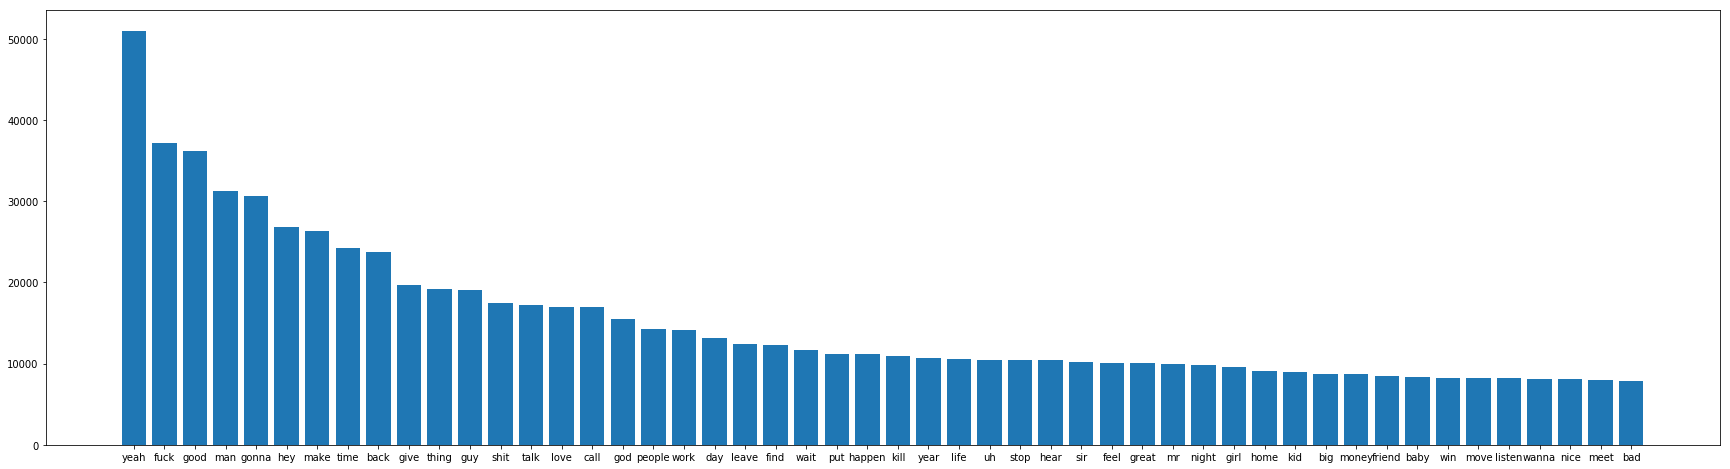

In [22]:
count_words=CountVectorizer(max_features=2000)
c_model=count_words.fit_transform(R_sub)
c_features=count_words.get_feature_names()

c_dt=pd.DataFrame(c_model.todense(),columns=c_features)
d=list(c_dt.sum())

c_features=list(c_features)
c_features_count=pd.DataFrame({'features':c_features,'count':d})
# plt.figure(figsize=(30,8))
# plt.bar(c_features[:50],d[:50])
c_features_count=c_features_count.sort_values(by=['count'],ascending=False)
plt.figure(figsize=(30,8))
plt.bar(c_features_count['features'][:50],c_features_count['count'][:50])

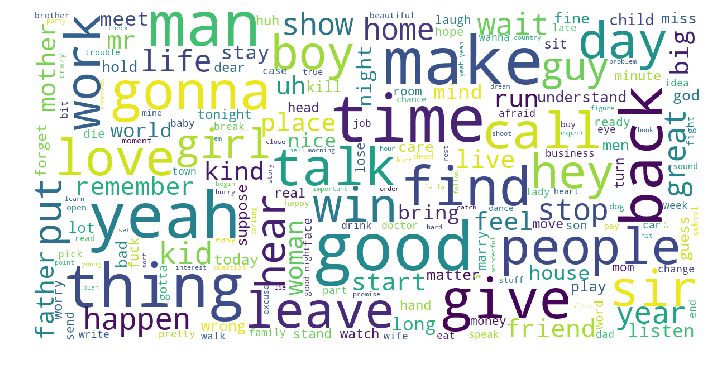

In [23]:
#NR
NR_sub=NR['subtitle'].values
NR_tokenized=[]
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec=TfidfVectorizer(max_features=2000)
tfidf_whtspc_stem=tfidf_vec.fit_transform(NR_sub)
tfidf_whtspc_stem_features=tfidf_vec.get_feature_names() 

final_features=final_features+tfidf_whtspc_stem_features


NR_features=tfidf_whtspc_stem_features
from collections import Counter
c=Counter(NR_features)

from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        #stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(NR_sub)

<BarContainer object of 50 artists>

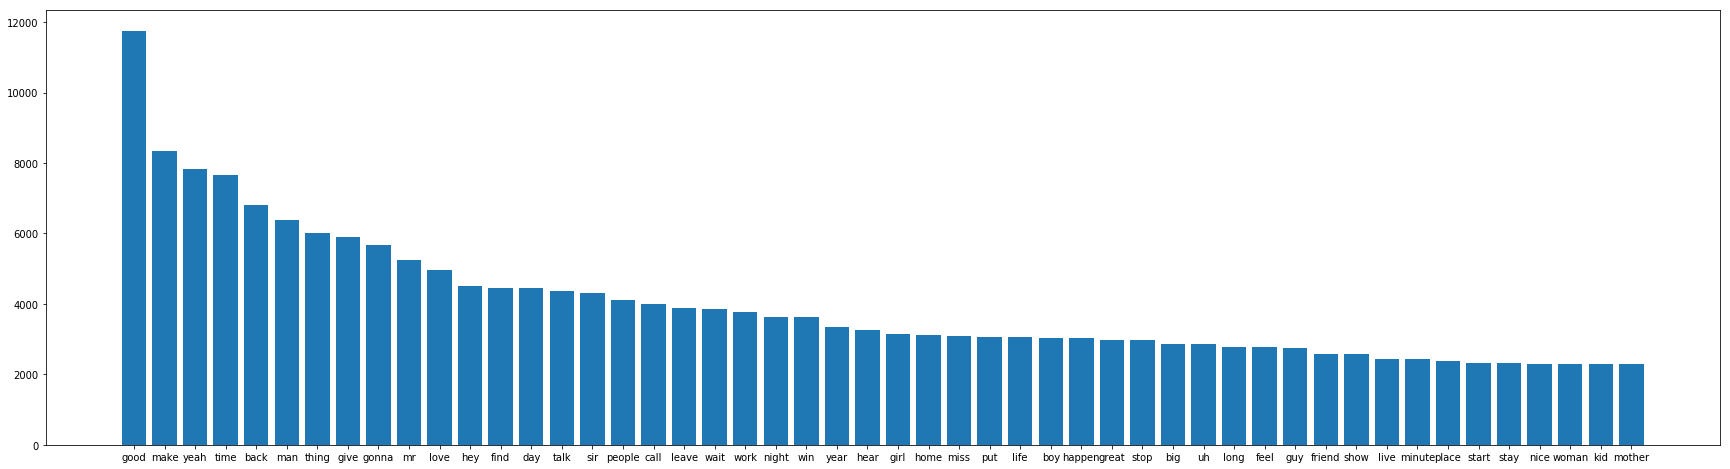

In [24]:
count_words=CountVectorizer(max_features=2000)
c_model=count_words.fit_transform(NR_sub)
c_features=count_words.get_feature_names()

c_dt=pd.DataFrame(c_model.todense(),columns=c_features)
d=list(c_dt.sum())

c_features=list(c_features)
c_features_count=pd.DataFrame({'features':c_features,'count':d})
# plt.figure(figsize=(30,8))
# plt.bar(c_features[:50],d[:50])
c_features_count=c_features_count.sort_values(by=['count'],ascending=False)
plt.figure(figsize=(30,8))
plt.bar(c_features_count['features'][:50],c_features_count['count'][:50])

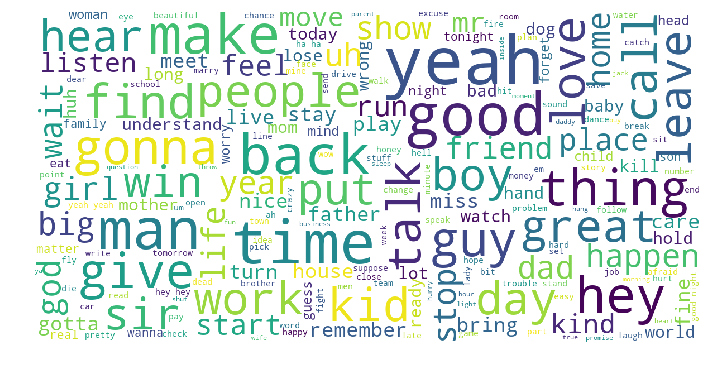

In [25]:
#PG
PG_sub=PG['subtitle'].values
PG_tokenized=[]

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec=TfidfVectorizer(max_features=2000)
tfidf_whtspc_stem=tfidf_vec.fit_transform(PG_sub)
tfidf_whtspc_stem_features=tfidf_vec.get_feature_names() 

final_features=final_features+tfidf_whtspc_stem_features

PG_features=tfidf_whtspc_stem_features
from collections import Counter
c=Counter(PG_features)

from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        #stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(PG_sub)



<BarContainer object of 50 artists>

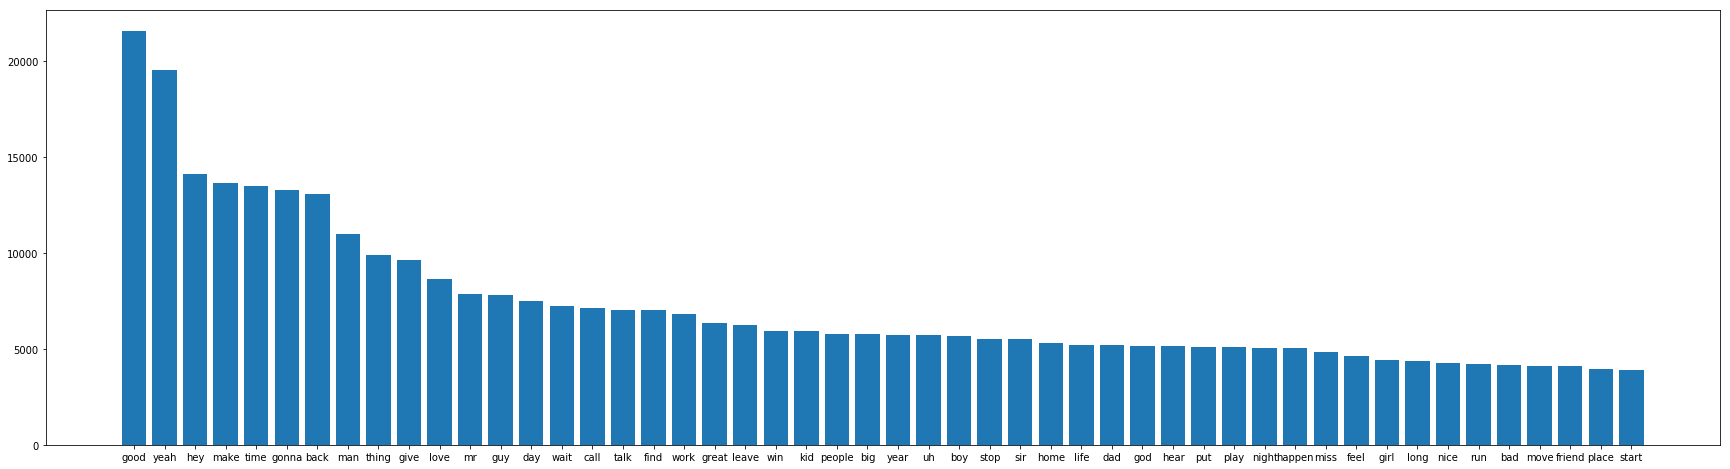

In [26]:
count_words=CountVectorizer(max_features=2000)
c_model=count_words.fit_transform(PG_sub)
c_features=count_words.get_feature_names()

c_dt=pd.DataFrame(c_model.todense(),columns=c_features)
d=list(c_dt.sum())

c_features=list(c_features)
c_features_count=pd.DataFrame({'features':c_features,'count':d})
# plt.figure(figsize=(30,8))
# plt.bar(c_features[:50],d[:50])
c_features_count=c_features_count.sort_values(by=['count'],ascending=False)
plt.figure(figsize=(30,8))
plt.bar(c_features_count['features'][:50],c_features_count['count'][:50])

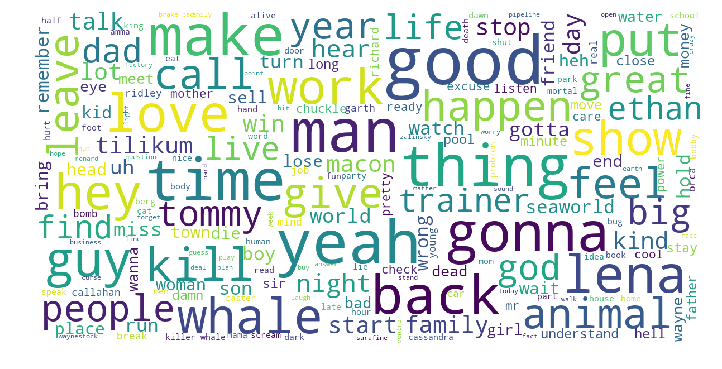

In [27]:
#PG_13
PG_13_sub=PG_13['subtitle'].values
PG_13_tokenized=[]

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec=TfidfVectorizer(max_features=2000)
tfidf_whtspc_stem=tfidf_vec.fit_transform(PG_13_sub)
tfidf_whtspc_stem_features=tfidf_vec.get_feature_names() 

final_features=final_features+tfidf_whtspc_stem_features

PG_features=tfidf_whtspc_stem_features
from collections import Counter
c=Counter(PG_features)
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        #stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(PG_13_sub)


<BarContainer object of 50 artists>

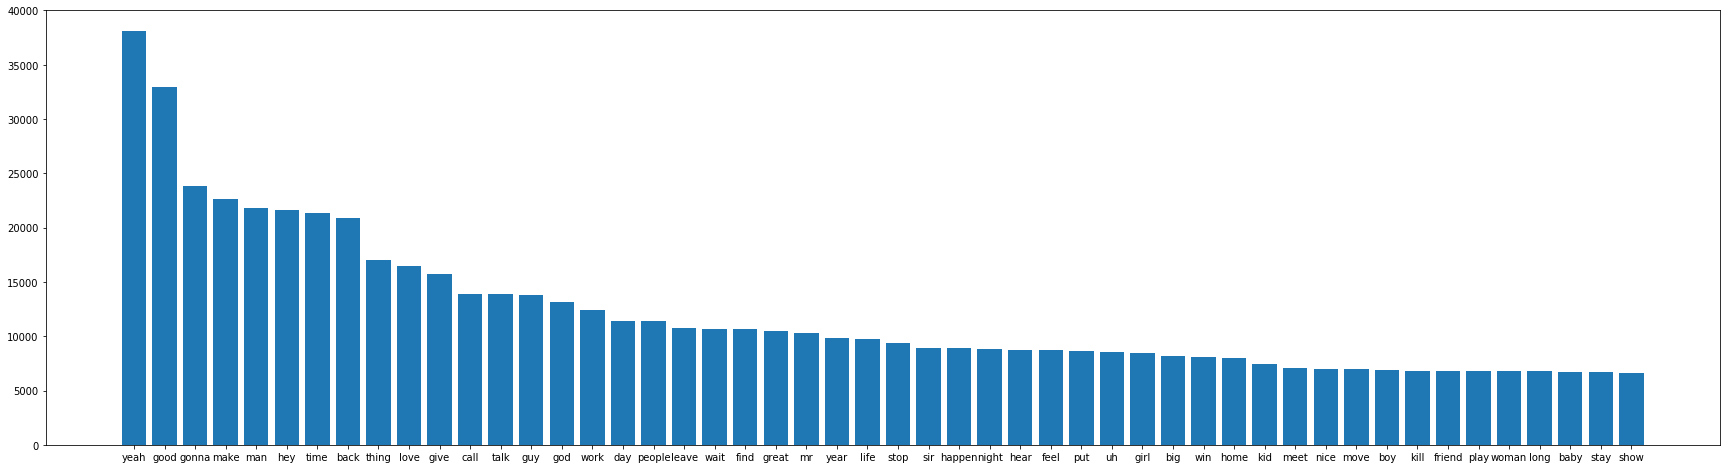

In [28]:
count_words=CountVectorizer(max_features=2000)
c_model=count_words.fit_transform(PG_13_sub)
c_features=count_words.get_feature_names()

c_dt=pd.DataFrame(c_model.todense(),columns=c_features)
d=list(c_dt.sum())

c_features=list(c_features)
c_features_count=pd.DataFrame({'features':c_features,'count':d})
# plt.figure(figsize=(30,8))
# plt.bar(c_features[:50],d[:50])
c_features_count=c_features_count.sort_values(by=['count'],ascending=False)
plt.figure(figsize=(30,8))
plt.bar(c_features_count['features'][:50],c_features_count['count'][:50])

### Let us vectorize the  prepared subtitles text and the words into features.Here we do it using tfidf vectorizer.


In [15]:
# creating the feature matrix 
from sklearn.feature_extraction.text import TfidfVectorizer
matrix = TfidfVectorizer(ngram_range=(1,3),max_features=30000)
tfidf_ = matrix.fit_transform(final_df['subtitle'])
tfidf_features=matrix.get_feature_names()

In [16]:
len(tfidf_features)

30000

In [17]:
#creating Dataframe from the features that we generated above
X=pd.DataFrame(tfidf_.todense(),columns=tfidf_features)


X_final=X
X_final.head()

,aa,aaaaah,aaaah,aaah,aaah aaah,aah,aah aah,aah aah aah,aah god,aah ha,...,zurich,ín,εmperor,ηe,ηey,οf,οn,οut,τhe,τommy
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.061043,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Seperating the data frame into X and Y.

In [25]:
y=final_df['MPAA_rating']
y=list(y)


In [26]:
import math
for i in range(len(final_df)):
    if type(final_df.iloc[i,3]) is float:
        final_df['title_tokenized']=final_df['title']

### Dummy encoding of Y

In [24]:
'''

from sklearn import preprocessing
number=preprocessing.LabelEncoder()
y_number=number.fit_transform(y)
len(y_number)


for i in range(len(y)):
    try:
        if y[i]=='R' or y[i]==' R':
            y[i]=1
        else:
            y[i]=0
    except :
        continue
'''


array([0, 0, 1, ..., 1, 1, 0])

In [27]:
tfidf_vec_title=TfidfVectorizer(max_df=12,min_df=1,ngram_range=(1,2))

# try:
#     tfidf_title=tfidf_vec_title.fit_transform(final_df['title_tokenized'])
# except :
#     continue
tfidf_title=tfidf_vec_title.fit_transform(final_df['title_tokenized'])
tfidf_features_title=tfidf_vec_title.get_feature_names()  




### forming a dataframe from the vectorized movie titles

In [28]:
title_=tfidf_title.todense()
title_X=pd.DataFrame(title_,columns=tfidf_features_title)



In [29]:
X=pd.concat([X_final,title_X],axis=1)
X.drop(['title'],axis=1,inplace=True)
X.head()



,aa,aaaaah,aaaah,aaah,aaah aaah,aah,aah aah,aah aah aah,aah god,aah ha,...,zissou,zodiac,zohan,zombieland,zone,zoo,zookeeper,zoolander,zorro,zurdo
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.061043,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### model fitting

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)


### One vs all

In [44]:
# svc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
clf = OneVsRestClassifier(SVC()).fit(X_train, y_train)
pred=clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

In [45]:
from sklearn.metrics import accuracy_score,classification_report,f1_score
from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(y_test,pred))
accuracy_score(y_test,pred)
f1_score(y_test,pred,average='weighted')

[[[1069    2]
  [  59    2]]

 [[1003    0]
  [ 123    6]]

 [[ 932    5]
  [ 180   15]]

 [[ 382  394]
  [ 108  248]]

 [[ 602  139]
  [  70  321]]]


0.45435746275486405

In [54]:
multilabel_confusion_matrix(y_test,pred)

array([[[1041,   30],
        [  37,   24]],

       [[ 955,   48],
        [  97,   32]],

       [[ 803,  134],
        [  99,   96]],

       [[ 584,  192],
        [  99,  257]],

       [[ 680,   61],
        [ 133,  258]]])

In [42]:
#logistic
from sklearn.linear_model import LogisticRegression
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear',penalty='l2',class_weight='balanced')).fit(X_train, y_train)
pred=clf.predict(X_test)

In [43]:
print(multilabel_confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(f1_score(y_test,pred,average='weighted'))

[[[1041   30]
  [  37   24]]

 [[ 959   44]
  [  94   35]]

 [[ 803  134]
  [  98   97]]

 [[ 583  193]
  [  88  268]]

 [[ 695   46]
  [ 130  261]]]
0.6051236749116607
0.6039256233834865


### multiclass

In [50]:
from sklearn.svm import LinearSVC
clf = LinearSVC(multi_class='crammer_singer',max_iter=100000).fit(X_train, y_train)
pred=clf.predict(X_test)

In [51]:
print(multilabel_confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(f1_score(y_test,pred,average='weighted'))

[[[1050   21]
  [  41   20]]

 [[ 963   40]
  [ 106   23]]

 [[ 802  135]
  [ 106   89]]

 [[ 600  176]
  [ 130  226]]

 [[ 628  113]
  [ 102  289]]]
0.5715547703180212
0.5609046354034214


In [52]:
from sklearn.linear_model import LogisticRegressionCV
clf=LogisticRegressionCV(class_weight='balanced',multi_class='multinomial',solver='lbfgs').fit(X_train, y_train)
pred=clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [53]:
print(multilabel_confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(f1_score(y_test,pred,average='weighted'))

[[[1041   30]
  [  37   24]]

 [[ 955   48]
  [  97   32]]

 [[ 803  134]
  [  99   96]]

 [[ 584  192]
  [  99  257]]

 [[ 680   61]
  [ 133  258]]]
0.5892226148409894
0.5870407037178891


### All pairs

In [58]:
from sklearn.svm import SVC
clf=SVC(class_weight='balanced',decision_function_shape='ovo').fit(X_train,y_train)
pred=clf.predict(X_test)


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [59]:
print(multilabel_confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(f1_score(y_test,pred,average='weighted'))

[[[   0 1071]
  [   0   61]]

 [[1003    0]
  [ 129    0]]

 [[ 937    0]
  [ 195    0]]

 [[ 776    0]
  [ 356    0]]

 [[ 741    0]
  [ 391    0]]]
0.053886925795053005
0.005510649578370885


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
#Logistic regression
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report



from sklearn.linear_model import LogisticRegression
logistic=LogisticRegression(solver='liblinear',penalty='l2',class_weight='balanced')
fit=logistic.fit(X_train,y_train)
pred=logistic.predict(X_test)
print(accuracy_score(y_test,pred))
# acc_test.append(accuracy_score(y_test,pred))
ytrain_pred=logistic.predict(X_train)
print(accuracy_score(y_train,ytrain_pred))
# acc_train.append(accuracy_score(y_train,ytrain_pred))

0.8356890459363958
0.986737400530504


In [41]:
#logisticregression cv,cv=5, l1 penalization.
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix

acc_train=[]
acc_test=[]
for i in range(5,10):
    logistic=LogisticRegressionCV(solver='liblinear',penalty='l1',cv=i,class_weight='balanced')
    fit=logistic.fit(X_train,y_train)
    ytrain_pred=logistic.predict(X_train)
    pred=logistic.predict(X_test)
    print(confusion_matrix(y_train,ytrain_pred))
    print('test accuracy',accuracy_score(y_test,pred))
    print('train accuracy',accuracy_score(y_train,ytrain_pred))
    acc_test.append(accuracy_score(y_test,pred))
acc_test
#Let us go with cv =5

[[1665   55]
 [ 267  652]]
test accuracy 0.8462897526501767
train accuracy 0.8779840848806366
[[1665   55]
 [ 268  651]]
test accuracy 0.8462897526501767
train accuracy 0.8776051534672225
[[1665   55]
 [ 267  652]]
test accuracy 0.8462897526501767
train accuracy 0.8779840848806366
[[1665   55]
 [ 267  652]]
test accuracy 0.8462897526501767
train accuracy 0.8779840848806366
[[1665   55]
 [ 268  651]]
test accuracy 0.8462897526501767
train accuracy 0.8776051534672225


[0.8462897526501767,
 0.8462897526501767,
 0.8462897526501767,
 0.8462897526501767,
 0.8462897526501767]

### Naive bayes

In [102]:
from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
ytrain_pred=gnb.fit(X_train,y_train).predict(X_train)
acc_tr=accuracy_score(y_train,ytrain_pred)
print('accuracy Naive Bayes:',accuracy)
acc_tr





accuracy Naive Bayes: 0.6996466431095406


0.8226600985221675

#### KNN

In [104]:
#knn
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5,weights='distance')
fit=knn.fit(X_train,y_train)
pred=knn.predict(X_test)
print(accuracy_score(y_test,pred))

0.6696113074204947


### Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier
# def RFC(X,y):
for i in range(100,1000,100):
    print(i)
    clf = RandomForestClassifier(n_estimators=i,max_depth=3,oob_score=True)
    clf.fit(X_train,y_train)
    feature_imp=clf.feature_importances_
    pred=clf.predict(X_test)
    acc=accuracy_score(y_test,pred)
    
    
    print('oob score',clf.oob_score_)
    print('test accuracy',acc)

100
100
oob score 0.7517999242137173
test accuracy 0.734982332155477
200
200
oob score 0.7389162561576355
test accuracy 0.7332155477031802
300
300
oob score 0.7411898446381205
test accuracy 0.7385159010600707
400
400
oob score 0.7404319818112921
test accuracy 0.7323321554770318
500
500
oob score 0.7343690791966654
test accuracy 0.7287985865724381
600
600
oob score 0.7328533535430087
test accuracy 0.7296819787985865
700
700
oob score 0.7396741189844638
test accuracy 0.7323321554770318
800
800
oob score 0.7389162561576355
test accuracy 0.730565371024735
900
900
oob score 0.7339901477832512
test accuracy 0.7314487632508834
